In [1]:
from FRP_Model_TEST import CopolymerizationModel, calculate_cm_params, calculate_lundberg_params
from CPE import CopolymerEquations
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
# f1 = 0.75
# r1 = 5
# r2 = 0.2
# b1 = 0.1
# g1 = 0.1
# b2 = 0.25
# g2 = 0.25

f1 = 0.75
r1 = 5
r2 = 0.2
b1 = 0.25
g1 = 0.25
b2 = 0.25
g2 = 0.25

inputs = np.array([f1, r1, r2, b1, g1, b2, g2])

cpe = CopolymerEquations.fromLundberg(inputs)

sol0 = cpe.solve_wittmer()
sol1 = cpe.solve_izu()
sol2 = cpe.solve_kruger()

X = sol0[0]
w_xA, w_xB = sol0[1], sol0[2]
i_xA, i_xB = sol1[1], sol1[2]
k_xA, k_xB = sol2[1], sol2[2]


In [3]:
def ssr(predicted_values, actual_values):
    residuals = predicted_values - actual_values
    ssr = np.sum(residuals**2)
    return ssr

In [4]:
k_cm0 , y0 = calculate_lundberg_params(f1, r1, r2, b1, g1, b2, g2, I0=0.005)
cm0 = CopolymerizationModel(k_cm0, y0)
cm0.solve([0, 10000], num_points=100)

/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:809: RuntimeWarning: invalid value encountered in divide
  self.CA = (self.A0 - self.cA) / (self.A0 - self.cA + self.B0 - self.cB)
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:810: RuntimeWarning: invalid value encountered in divide
  self.CB = (self.B0 - self.cB) / (self.A0 - self.cA + self.B0 - self.cB)
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:881: RuntimeWarning: invalid value encountered in divide
  self.aNASL_A = self.aSA_1 / self.aSA_0
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:882: RuntimeWarning: invalid value encountered in divide
  self.aNASL_B = self.aSB_1 / self.aSB_0
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:883: RuntimeWarning: invalid value encountered in divide
  self.aWASL_A = self.aSA_2 / self.aSA_1
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:884: RuntimeWarning: invalid value encountered in divide
  self.aWASL_B = self.aSB_2 / self.aSB_1
/home/devon/Documents/

(0.0, 1.2)

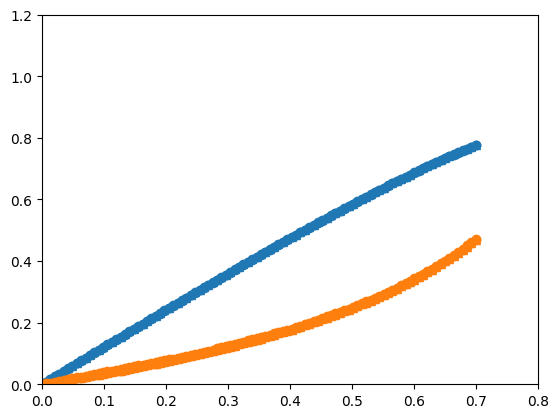

In [5]:

from CPE import CopolymerEquations

cmX = (cm0.A0 + cm0.B0 - cm0.cA - cm0.cB) / (cm0.A0 + cm0.B0)

# I want to make an interpolate function to take in x1 and y1 and x2 and return y2
def interpolate(x1, y1, x2):
    f = interp1d(x1, y1, fill_value='extrapolate')
    y2 = f(x2)
    return y2

o_xA = interpolate(cmX, cm0.xA, X)
o_xB = interpolate(cmX, cm0.xB, X)

color_A = 'tab:blue'
color_B = 'tab:orange'

plt.plot(X, w_xA, 'o', label='Wittmer (A)', color=color_A)
plt.plot(X, w_xB, 'o', label='Wittmer (B)', color=color_B)

plt.plot(X, i_xA, '^', label='Izu (A)', color=color_A)
plt.plot(X, i_xB, '^', label='Izu (B)', color=color_B)

plt.plot(X, k_xA, '-', label='Kruger (A)', color=color_A)
plt.plot(X, k_xB, '-', label='Kruger (B)', color=color_B)

plt.plot(X, o_xA, 'o', label='CM (A)', color=color_A)
plt.plot(X, o_xB, 'o', label='CM (A)', color=color_B)
plt.xlim([0, 0.8])
plt.ylim([0, 1.2])

In [6]:
0.01*0.01*100

0.01

In [7]:
print(ssr(i_xA, w_xA))
print(ssr(i_xA, k_xA))
print(ssr(i_xA, o_xA))
print(ssr(w_xB, o_xB))

3.311203863503681e-14
2.559815092645552e-14
0.000181647265082835
0.0016347984367720302


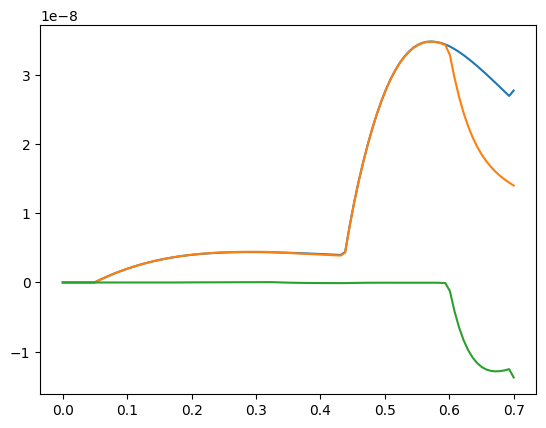

In [8]:
plt.plot(X,(i_xA-w_xA), label='Izu-Wittmer')
plt.plot(X,(i_xA-k_xA), label='Izu-Kruger')
plt.plot(X,(w_xA-k_xA), label='Wittmer-Kruger')
# plt.plot(X,(o_xA-w_xA)/w_xA*100, label='CM-Wittmer')
# plt.plot(X,(o_xA-i_xA)/i_xA*100, label='CM-Izu')
# plt.plot(X,(o_xA-k_xA)/k_xA*100, label='CM-Kruger')
# plt.legend()

In [20]:
import signal

# Define a timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Set the timeout signal
signal.signal(signal.SIGALRM, timeout_handler)

timeout_duration = 15

In [40]:
import pandas as pd

df = pd.read_csv('LundbergSSR.csv')

ssr_list = []

for index, row in df.iterrows():
    
    try:
        signal.alarm(timeout_duration)
        fA0 = row['fA0']
        rA = row['rA']
        rB = row['rB']
        b1 = row['b1']
        g1 = row['g1']
        b2 = row['b2']
        g2 = row['g2']

        inputs = np.array([fA0, rA, rB, b1, g1, b2, g2])
    
        k_cm0 , y0 = calculate_lundberg_params(fA0, rA, rB, b1, g1, b2, g2, I0=0.001)
        
        print(k_cm0)
        cm0 = CopolymerizationModel(k_cm0, y0)
        cm0.solve([0, 4000], num_points=100)
        cmX = cm0.x
        
        cpe = CopolymerEquations.fromLundberg(inputs)
        
        cpe.set_bounds([0, np.max(cmX)])
        
        sol0 = cpe.solve_izu()
        # sol1 = cpe.solve_izu()
        # sol2 = cpe.solve_kruger()
        
        X = sol0[0]
        w_xA, w_xB = sol0[1], sol0[2]

        o_xA = interpolate(cmX, cm0.xA, X)
        o_xB = interpolate(cmX, cm0.xB, X)
        
        my_ssr = ssr(w_xA, o_xA)
        # ssr_list.append(my_ssr)
        print(index, my_ssr)
        
        # plt.plot(X, w_xA, 'o', label='Wittmer (A)', color=color_A)
        # plt.plot(X, w_xB, 'o', label='Wittmer (B)', color=color_B)
        
        # plt.plot(X, o_xA, '-', label='CM (A)', color=color_A)
        # plt.plot(X, o_xB, '-', label='CM (A)', color=color_B)
        # plt.show()
        
    except TimeoutException:
        my_ssr = -1
        print(f'Iteration {index} timed out.')
    
    finally:
        signal.alarm(0)
        ssr_list.append(my_ssr)


df['SSR'] = ssr_list
df.to_csv('IzuLundbergSSR.csv', index=False)

[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 4e-08, 1e-07, 4e-08, 1e-07, 0, 0, 0, 0, 0, 0]


/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:809: RuntimeWarning: invalid value encountered in divide
  self.CA = (self.A0 - self.cA) / (self.A0 - self.cA + self.B0 - self.cB)
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:810: RuntimeWarning: invalid value encountered in divide
  self.CB = (self.B0 - self.cB) / (self.A0 - self.cA + self.B0 - self.cB)
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:881: RuntimeWarning: invalid value encountered in divide
  self.aNASL_A = self.aSA_1 / self.aSA_0
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:882: RuntimeWarning: invalid value encountered in divide
  self.aNASL_B = self.aSB_1 / self.aSB_0
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:883: RuntimeWarning: invalid value encountered in divide
  self.aWASL_A = self.aSA_2 / self.aSA_1
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:884: RuntimeWarning: invalid value encountered in divide
  self.aWASL_B = self.aSB_2 / self.aSB_1
/home/devon/Documents/

0 6.604410888678772e-06
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 0.04, 0.25, 0.4, 0.5, 0, 0, 0, 0, 0, 0]
1 1.666678415030054e-05
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 0.1, 5e-08, 1.0, 1e-07, 0, 0, 0, 0, 0, 0]
2 2.3726313794480363e-06
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 4e-08, 1e-06, 2e-08, 1e-07, 0, 0, 0, 0, 0, 0]
3 6.604426764734865e-06
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 0.2, 2e-07, 0.4, 1e-07, 0, 0, 0, 0, 0, 0]
4 4.3081608365237886e-06
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 2e-08, 7.5, 2e-07, 0.75, 0, 0, 0, 0, 0, 0]
5 0.0010158268178809312
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 0.05, 1e-06, 0.05, 1e-07, 0, 0, 0, 0, 0, 0]
6 5.955677375745722e-06
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 0.1, 0.25, 0.2, 0.25, 0, 0, 0, 0, 0, 0]
7 8.804020708498722e-06
[1e+20, 1.0, 1, 0.48007681228996635, 1.6666666666666667, 1, 2e-08, 0.375, 2e-08, 0.75, 0,

/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:898: RuntimeWarning: invalid value encountered in sqrt
  self.iNASL_std_A = np.sqrt((self.iSDI_A - 1) * self.iNASL_A)


36 1.4421138462620549e-07
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 9e-08, 5.0, 9e-08, 0.5, 0, 0, 0, 0, 0, 0]
37 1.1277672903262694e-06
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 0.45, 0.375, 0.045, 0.75, 0, 0, 0, 0, 0, 0]
38 4.584304892101329e-07
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 0.09, 0.05, 0.18, 0.5, 0, 0, 0, 0, 0, 0]
39 9.754076804570137e-05
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 0.05, 0.25, 0.05, 0.5, 0, 0, 0, 0, 0, 0]
40 0.00018029846197739732
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 0.05, 0.1, 0.5, 0.1, 0, 0, 0, 0, 0, 0]
41 2.114827244140559e-05
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 0.05, 1e-07, 0.05, 1e-07, 0, 0, 0, 0, 0, 0]
42 6.971239418542632e-05
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 2e-08, 1e-07, 1e-08, 1e-07, 0, 0, 0, 0, 0, 0]
43 0.00010364573875871401
[1e+20, 1.0, 1, 0.14999250037498124, 3.3333333333333335, 1, 2e-08, 0.05, 2e-07,

/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:889: RuntimeWarning: invalid value encountered in sqrt
  self.aNASL_std_B = np.sqrt((self.aSDI_B - 1) * self.aNASL_B)
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:899: RuntimeWarning: invalid value encountered in sqrt
  self.iNASL_std_B = np.sqrt((self.iSDI_B - 1) * self.iNASL_B)
/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:909: RuntimeWarning: invalid value encountered in sqrt
  self.NASL_std_B = np.sqrt((self.SDI_B - 1) * self.NASL_B)


59 1.97431671521582e-06
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.175, 0.25, 0.0175, 0.25, 0, 0, 0, 0, 0, 0]
60 1.4597625121762837e-05
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.175, 0.1, 1.75, 0.1, 0, 0, 0, 0, 0, 0]
61 1.2613675675573134e-05
[1e+20, 1.0, 1, 0.04, 10.0, 1, 7e-08, 0.75, 7e-09, 0.75, 0, 0, 0, 0, 0, 0]
62 1.6252018493925676e-05
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.07, 0.75, 0.07, 0.75, 0, 0, 0, 0, 0, 0]
63 1.5819820439181357e-05
[1e+20, 1.0, 1, 0.04, 10.0, 1, 7e-08, 1.5, 3.5e-08, 0.75, 0, 0, 0, 0, 0, 0]
64 1.148457719396291e-06
[1e+20, 1.0, 1, 0.04, 10.0, 1, 9e-08, 2e-07, 9e-09, 1e-07, 0, 0, 0, 0, 0, 0]
65 1.0882008339523015e-06
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.225, 0.125, 0.225, 0.25, 0, 0, 0, 0, 0, 0]
66 1.050960936075908e-06
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.45, 1e-08, 0.9, 1e-07, 0, 0, 0, 0, 0, 0]
67 9.306590405655659e-07
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.09, 5.0, 0.009, 0.5, 0, 0, 0, 0, 0, 0]
68 6.770308585027299e-08
[1e+20, 1.0, 1, 0.04, 10.0, 1, 0.225, 2.5, 0.225, 0.25, 0, 0, 0, 0, 0, 0]
6

/home/devon/miniconda3/envs/hybrid/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:339: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/home/devon/miniconda3/envs/hybrid/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:308: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/home/devon/miniconda3/envs/hybrid/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/devon/miniconda3/envs/hybrid/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


79 0.0005691618874209413
[1e+20, 1.0, 1, 100.0, 100.0, 1, 8e-08, 0.25, 8e-07, 0.25, 0, 0, 0, 0, 0, 0]
80 0.0005977936527675434
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.6, 0.05, 1.2, 0.5, 0, 0, 0, 0, 0, 0]
81 0.0007694093593885303
[1e+20, 1.0, 1, 100.0, 100.0, 1, 8e-08, 0.375, 8e-08, 0.75, 0, 0, 0, 0, 0, 0]
82 0.0005963615603586294
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.2, 0.05, 0.2, 0.1, 0, 0, 0, 0, 0, 0]
Iteration 83 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 8e-08, 0.2, 8e-08, 0.1, 0, 0, 0, 0, 0, 0]
84 0.00042891571186924084
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.225, 0.25, 2.25, 0.25, 0, 0, 0, 0, 0, 0]


/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:908: RuntimeWarning: invalid value encountered in sqrt
  self.NASL_std_A = np.sqrt((self.SDI_A - 1) * self.NASL_A)


85 1.4453887786807006e-05
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.09, 5.0, 0.009, 0.5, 0, 0, 0, 0, 0, 0]


/home/devon/miniconda3/envs/hybrid/lib/python3.12/site-packages/scipy/integrate/_ivp/bdf.py:231: LinAlgWarning: Diagonal number 33 is exactly zero. Singular matrix.
  return lu_factor(A, overwrite_a=True)


Iteration 86 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.45, 0.01, 0.045, 0.1, 0, 0, 0, 0, 0, 0]
Iteration 87 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.675, 0.01, 0.3375, 0.1, 0, 0, 0, 0, 0, 0]
Iteration 88 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.09, 1.0, 0.009, 0.1, 0, 0, 0, 0, 0, 0]
Iteration 89 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.1, 5e-08, 0.1, 1e-07, 0, 0, 0, 0, 0, 0]


/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:888: RuntimeWarning: invalid value encountered in sqrt
  self.aNASL_std_A = np.sqrt((self.aSDI_A - 1) * self.aNASL_A)


90 0.00959141767902251
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.1, 0.05, 0.1, 0.1, 0, 0, 0, 0, 0, 0]
Iteration 91 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 2e-08, 0.075, 1e-08, 0.75, 0, 0, 0, 0, 0, 0]
92 0.011375359129130626
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.05, 1.0, 0.05, 0.1, 0, 0, 0, 0, 0, 0]
93 0.00020149920945017276
[1e+20, 1.0, 1, 100.0, 100.0, 1, 2e-08, 0.1, 2e-08, 0.1, 0, 0, 0, 0, 0, 0]
94 0.00046575137271821104
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.175, 0.125, 0.175, 0.25, 0, 0, 0, 0, 0, 0]
95 1.2908457789911547e-05
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.175, 5e-08, 0.0875, 1e-07, 0, 0, 0, 0, 0, 0]
Iteration 96 timed out.
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.07, 0.1, 0.035, 0.1, 0, 0, 0, 0, 0, 0]


/home/devon/Documents/ReversibleCRP/FRP_Model_TEST.py:908: RuntimeWarning: invalid value encountered in multiply
  self.NASL_std_A = np.sqrt((self.SDI_A - 1) * self.NASL_A)


97 0.00037374838269907726
[1e+20, 1.0, 1, 100.0, 100.0, 1, 0.525, 0.2, 0.525, 0.1, 0, 0, 0, 0, 0, 0]
98 0.0005003379819806333
[1e+20, 1.0, 1, 100.0, 100.0, 1, 7e-08, 0.75, 7e-08, 0.75, 0, 0, 0, 0, 0, 0]
99 0.000459658406103607
[1e+20, 1.0, 1, 10.0, 10.0, 1, 0.25, 1e-07, 2.5, 1e-07, 0, 0, 0, 0, 0, 0]
100 1.4252889800534992e-06
[1e+20, 1.0, 1, 10.0, 10.0, 1, 0.375, 1e-07, 0.375, 1e-07, 0, 0, 0, 0, 0, 0]
101 2.0319538757004729e-07
[1e+20, 1.0, 1, 10.0, 10.0, 1, 0.375, 2.5, 0.375, 0.25, 0, 0, 0, 0, 0, 0]
102 7.050818320819353e-07
[1e+20, 1.0, 1, 10.0, 10.0, 1, 0.05, 0.25, 0.005, 0.25, 0, 0, 0, 0, 0, 0]
103 3.0528854777866494e-06
[1e+20, 1.0, 1, 10.0, 10.0, 1, 0.125, 0.375, 0.125, 0.75, 0, 0, 0, 0, 0, 0]
104 6.235661335559834e-05
[1e+20, 1.0, 1, 10.0, 10.0, 1, 3e-08, 1e-07, 3e-08, 1e-07, 0, 0, 0, 0, 0, 0]
105 6.131906539887458e-05
[1e+20, 1.0, 1, 10.0, 10.0, 1, 3e-08, 0.75, 3e-09, 0.75, 0, 0, 0, 0, 0, 0]
106 5.479741915341587e-05
[1e+20, 1.0, 1, 10.0, 10.0, 1, 3e-08, 1.0, 3e-07, 0.1, 0, 0, 

(1e-08, 1)

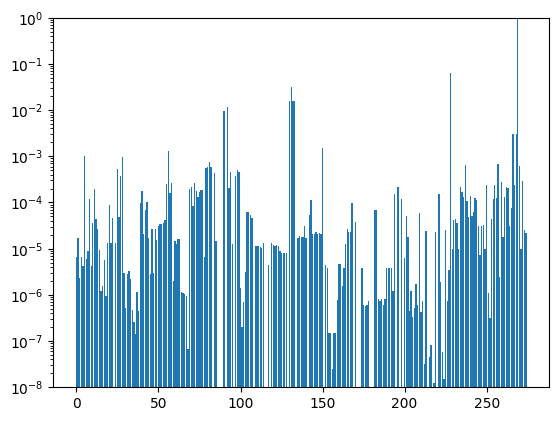

In [41]:
df_ = pd.read_csv('IzuLundbergSSR.csv')
plt.bar(df_.index, df_['SSR'])
plt.yscale('log')
plt.ylim([1e-8, 1])

(1e-08, 1)

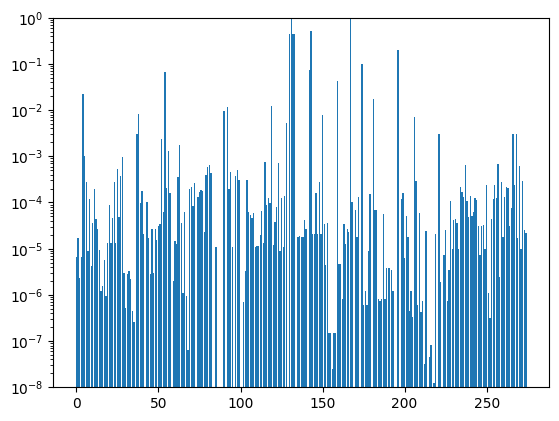

In [26]:
df_ = pd.read_csv('UpdatedLundbergSSR.csv')
plt.bar(df_.index, df_['SSR'])
plt.yscale('log')
plt.ylim([1e-8, 1])

In [44]:
new_df = df_[df_['SSR']<0]
print(len(new_df))
new_df

26


,fA0,rA,rB,b1,g1,b2,g2,max ssr,SSR
23,0.1,2.083,0.600000,5.000000e-02,2.500000e-02,7.500000e-01,1.500000e+00,0.000041,-1.0
83,0.8,0.010,0.010000,2.000000e-01,2.000000e-01,1.000000e-01,5.000000e-02,0.000501,-1.0
86,0.9,0.010,0.010000,9.000000e-02,9.000000e-03,5.000000e-01,5.000000e+00,0.000122,-1.0
87,0.9,0.010,0.010000,4.500000e-01,4.500000e-02,1.000000e-01,1.000000e-02,0.000021,-1.0
88,0.9,0.010,0.010000,6.750000e-01,3.375000e-01,1.000000e-01,1.000000e-02,0.000014,-1.0
89,0.2,0.010,0.010000,9.000000e-02,9.000000e-03,1.000000e-01,1.000000e+00,0.000066,-1.0
91,0.2,0.010,0.010000,1.000000e-01,1.000000e-01,1.000000e-01,5.000000e-02,0.000025,-1.0
96,0.7,0.010,0.010000,1.750000e-01,8.750000e-02,1.000000e-07,5.000000e-08,0.000133,-1.0
108,0.3,0.100,0.100000,7.500000e-02,7.500000e-02,1.000000e-07,2.000000e-07,0.000093,-1.0
115,0.4,0.100,0.100000,3.000000e-01,3.000000e-01,1.000000e-07,1.000000e-06,0.000062,-1.0
